In [ ]:
!nvidia-smi

Sun Jul  3 09:03:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/MalMem/
!ls

Mounted at /content/gdrive
gdrive	sample_data
/content/gdrive/My Drive/MalMem
 adasyn_tl_xgboost_balance.ipynb
 adasyn_tl_xgboost_balance_noRUS.ipynb
 adasyn_tl_xgboost_imbalanced.ipynb
 clf_readcsv.py
 CNN_MalMem_balance
 CNN_MalMem_imbalance
 createCNN_Balanced.ipynb
 createCNN_Balanced_noRUS.ipynb（副本）
 createCNN_Imbalanced.ipynb
'Dynamic Malware Analysis with Feature Engineering and Feature Learning.pdf'
 ensemble_major_imb.ipynb
 ensemble_major.ipynb
 evaluate_auc_3Algorithm_micro.ipynb
 Evaluate_PR_3Algorithms.ipynb
 Evaluate_PR_CNN.ipynb
 Evaluate_PR_Voting_imb.ipynb
 Evaluate_PR_Voting.ipynb
 evaluate_PR_xgboost_imb.ipynb
 evaluate_PR_xgboost.ipynb
 evaluation_MM.xlsx
 logs
 MalMem_Test_x.csv
 MalMem_Test_y.csv
 MalMem_Train_x.csv
 MalMem_Train_y.csv
 MalMem_x.csv
 MalMem_y.csv
'Malware Memory Analysis _ Datasets _ Canadian Institute for Cybersecurity _ UNB.mhtml'
 myXgb_adasyn_MalMem_imb.json
 myXgb_adasyn_MalMem.json
 Obfuscated-MalMem2022.csv
 Obfuscated-MalMem2022-excel.xlsx

In [2]:
pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 37 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


test_x          0         1         2         3         4         5         6   \
0 -0.587615  0.107713 -0.778478 -0.302401 -0.972787 -0.783229 -0.439421   
1 -0.068333 -1.021497  1.290864  0.526254  1.025516  1.517175  0.473084   
2  0.104762  0.484116 -0.559920 -0.285955 -0.508841 -0.799160 -0.247715   
3 -0.068333 -0.268691  0.858378  0.366127  0.725316  1.095824  0.322267   
4 -0.241427  0.484116 -1.175315 -0.388084 -0.933367 -1.068066 -0.430380   

         7         8         9   ...        40        41        42        43  \
0 -0.245733 -0.076951 -0.885724  ... -0.484390  0.194377 -0.518261 -0.204202   
1  0.389141  0.055321  1.036174  ... -0.672147  0.194377  0.806340  0.298040   
2 -0.196961 -0.013437 -0.672180  ... -0.341833  0.194377 -0.518261 -0.204202   
3  0.266459  0.043667  0.691027  ... -0.095600  0.194377  0.806340  0.298040   
4 -0.311379 -0.071998 -0.875792  ...  0.643100  0.194377 -0.518261 -0.204202   

         44        45        46        47        48        49

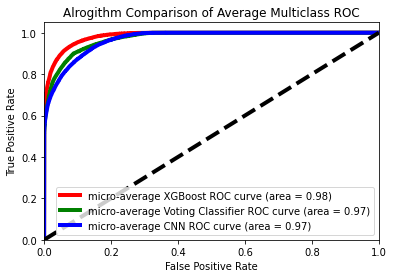

'\nprint(\n    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "\n    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)\n)\nprint(\n    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "\n    "(weighted by prevalence),\n{:.6f}"   #leon\n    "(micro)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr, roc_auc["micro"])  #leon\n\n)\n'

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  8 11:13:03 2022

load adasyn and xgbboost balanced model, test on 20% test dataset and evaluate
try using ROC curve
@author: Administrator
"""
# import joblib
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, \
    classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
# train_x = pd.read_csv('KDDTrain_x_20.csv',header=None)
# train_Y = pd.read_csv('KDDTrain_y_20.csv',header=None)
# train_Y[0]=list(train_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))

# print("train_x", train_x.head())
# print("train_y", train_Y.head())


#testing dataset 20%
test_x = pd.read_csv('MalMem_Test_x.csv',header=None)
test_Y = pd.read_csv('MalMem_Test_y.csv',header=None)

#test_Y[0]=list(test_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))
print("test_x", test_x.head())
print("test_y", test_Y.head())

test_Y  = test_Y.values.ravel()
print('test dataset shape %s' % Counter(test_Y))


# load model
#xgboost
clf = xgb.XGBClassifier()
clf.load_model("myXgb_adasyn_MalMem.json")
#voting
import joblib
clf_vt = joblib.load("VotingClassifier_MalMem_balance.pkl")
#CNN
from tensorflow import keras
import tensorflow as tf

model = tf.keras.models.load_model('CNN_MalMem_balance')
#class_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
#class_names_num = ['0', '1', '2', '3', '4']
class_names = ['Benign 0', 'Spyware 1', 'Ransomware 2', 'Trojan 3']
class_names_num = ['0', '1', '2', '3']

#metrics
#subset test data
# pred_y = clf.predict(test_x)
# results = confusion_matrix(test_Y, pred_y)
# error = zero_one_loss(test_Y, pred_y)
#target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
target_names = ['Benign 0', 'Spyware 1', 'Ransomware 2', 'Trojan 3']
# print("20% result: \n" , results)
# print("20% error:", error)
# print("20% validation:", accuracy_score(test_Y, pred_y))
# print(classification_report(test_Y, pred_y, target_names=target_names))

# after tomek link 
#pred_y = clf.predict(test_x)  #x_res
#pred_y_vt = clf_vt.predict(test_x)  #voting
"""
results = confusion_matrix(test_Y, pred_y)   #Y_res
error = zero_one_loss(test_Y, pred_y)   #Y_res
target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
print("20% result: \n" , results)
print("20% error:", error)
print("20% validation:", accuracy_score(test_Y, pred_y))   #Y_res
"""
yy = clf.predict_proba(test_x)  #xgboost
yy_vt = clf_vt.predict_proba(test_x)  #Voting
yy_cnn = model.predict(test_x)  #CNN

# yy = clf.decision_function(x_res)[:, 1]

#rac = roc_auc_score(test_Y, yy, multi_class='ovr', average ='macro')  #Y_res
#print("ROC AUC Score:", rac)
#print(classification_report(test_Y, pred_y, target_names=target_names))   #Y_res


#print(classification_report_imbalanced(test_Y, pred_y, target_names=target_names))  #Y_res
#print(f"The geometric mean is {geometric_mean_score(test_Y, pred_y):.3f}") #Y_res

"""
cm = confusion_matrix(test_Y, pred_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
_ = disp.ax_.set_title("XGBoost")
plt.show()
"""
# ***plot confusion matrix
# plt.matshow(results, cmap=plt.cm.gray)
# plt.show()


# plot roc curve
y = label_binarize(test_Y, classes=[0, 1, 2, 3])  #4 classes
n_classes = y.shape[1]

print("y:", y)
print("n_classes:", n_classes)

lw = 4

fpr = dict()
tpr = dict()
roc_auc = dict()

#voting
fpr_vt = dict()
tpr_vt = dict()
roc_auc_vt = dict()

#CNN
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

#xgboost
for i in range(n_classes):
    fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area  # xgboost
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), yy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


#voting
for i in range(n_classes):
    fpr_vt[i], tpr_vt[i], threshold_vt = roc_curve(y[:, i], yy_vt[:, i])
    roc_auc_vt[i] = auc(fpr_vt[i], tpr_vt[i])
# Compute micro-average ROC curve and ROC area
fpr_vt["micro"], tpr_vt["micro"], _ = roc_curve(y.ravel(), yy_vt.ravel())
roc_auc_vt["micro"] = auc(fpr_vt["micro"], tpr_vt["micro"])

#CNN
for i in range(n_classes):
    fpr_cnn[i], tpr_cnn[i], threshold_cnn = roc_curve(y[:, i], yy_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
# Compute micro-average ROC curve and ROC area
fpr_cnn["micro"], tpr_cnn["micro"], _ = roc_curve(y.ravel(), yy_cnn.ravel())
roc_auc_cnn["micro"] = auc(fpr_cnn["micro"], tpr_cnn["micro"])

"""
#xgboost macro
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
"""

# Plot all ROC curves
plt.figure()
#xgboost
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average XGBoost ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="red", # "deeppink",
    linestyle="-",
    linewidth=4,
)
#voting
plt.plot(
    fpr_vt["micro"],
    tpr_vt["micro"],
    label="micro-average Voting Classifier ROC curve (area = {0:0.2f})".format(roc_auc_vt["micro"]),
    color="green", #color="navy",
    linestyle="-",
    linewidth=4,
)
#cnn
plt.plot(
    fpr_cnn["micro"],
    tpr_cnn["micro"],
    label="micro-average CNN ROC curve (area = {0:0.2f})".format(roc_auc_cnn["micro"]),
    color="blue", #color="navy",
    linestyle="-",
    linewidth=4,
)

"""
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average XGBoost ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
"""



"""
colors = cycle(["aqua", "darkorange", "cornflowerblue", "#FF6666", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
"""

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Alrogithm Comparison of Average Multiclass ROC")
plt.legend(loc="lower right")
plt.show()


# compute roc_auc_score
# y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(test_Y, yy, multi_class="ovo", average="macro")  #Y_res
weighted_roc_auc_ovo = roc_auc_score(test_Y, yy, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="weighted") #Y_res
#micro_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="micro")   #leon
"""
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence),\n{:.6f}"   #leon
    "(micro)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr, roc_auc["micro"])  #leon

)
"""